## Importing Data

In [1]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages/

Looking in links: file:///kaggle/input/pip-packages/
Processing /kaggle/input/pip-packages/tabpfn-0.1.9-py3-none-any.whl


In [2]:
!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [3]:
import sys
import time
import csv
import datetime

import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import lightgbm as lgb
import catboost as ct
import tensorflow as tf

from datetime import date, datetime
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import log_loss, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, balanced_accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import Pool, CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from tabpfn import TabPFNClassifier

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
train_csv=pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
greeks_csv=pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")
test_csv=pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")

In [5]:
train_csv.describe().T

,count,mean,std,min,25%,50%,75%,max
AB,617.0,0.477149,0.468388,0.081187,0.252107,0.354659,0.559763,6.161666
AF,617.0,3502.013221,2300.322717,192.593280,2197.345480,3120.318960,4361.637390,28688.187660
AH,617.0,118.624513,127.838950,85.200147,85.200147,85.200147,113.739540,1910.123198
AM,617.0,38.968552,69.728226,3.177522,12.270314,20.533110,39.139886,630.518230
AR,617.0,10.128242,10.518877,8.138688,8.138688,8.138688,8.138688,178.943634
AX,617.0,5.545576,2.551696,0.699861,4.128294,5.031912,6.431634,38.270880
AY,617.0,0.060320,0.416817,0.025578,0.025578,0.025578,0.036845,10.315851
AZ,617.0,10.566447,4.350645,3.396778,8.129580,10.461320,12.969516,38.971568
BC,617.0,8.053012,65.166943,1.229900,1.229900,1.229900,5.081244,1463.693448
BD,617.0,5350.388655,3021.326641,1693.624320,4155.702870,4997.960730,6035.885700,53060.599240


In [6]:
# Check for Normalised Data
for column_name in train_csv.columns:

    column_data = train_csv[column_name]

    if np.issubdtype(column_data.dtype, np.number):
        
        mean = column_data.mean()
        std = column_data.std()

        if abs(mean) < 1e-8 and abs(std - 1) < 1e-8:
            print(f"The column '{column_name}' is normalized.")
        else:
            print(f"The column '{column_name}' is not normalized.")
    else:
        print(f"The column '{column_name}' is not a numeric column and is excluded from normalization check.")

The column 'Id' is not a numeric column and is excluded from normalization check.
The column 'AB' is not normalized.
The column 'AF' is not normalized.
The column 'AH' is not normalized.
The column 'AM' is not normalized.
The column 'AR' is not normalized.
The column 'AX' is not normalized.
The column 'AY' is not normalized.
The column 'AZ' is not normalized.
The column 'BC' is not normalized.
The column 'BD ' is not normalized.
The column 'BN' is not normalized.
The column 'BP' is not normalized.
The column 'BQ' is not normalized.
The column 'BR' is not normalized.
The column 'BZ' is not normalized.
The column 'CB' is not normalized.
The column 'CC' is not normalized.
The column 'CD ' is not normalized.
The column 'CF' is not normalized.
The column 'CH' is not normalized.
The column 'CL' is not normalized.
The column 'CR' is not normalized.
The column 'CS' is not normalized.
The column 'CU' is not normalized.
The column 'CW ' is not normalized.
The column 'DA' is not normalized.
The c

## Preprocessing Data

In [7]:
merged_train_csv = pd.merge(train_csv, greeks_csv, on='Id', how='inner')
print(merged_train_csv.shape)
merged_train_csv.head()

(617, 63)


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


In [8]:
train_csv['EJ'] = train_csv['EJ'].replace({'A': 0, 'B': 1})
test_csv['EJ'] = test_csv['EJ'].replace({'A': 0, 'B': 1})

greeks_csv['Beta'] = greeks_csv['Beta'].replace({'C': 2, 'B': 1, 'A': 0})
merged_train_csv['Beta'] = merged_train_csv['Beta'].replace({'C': 2, 'B': 1, 'A': 0})

greeks_csv['Gamma'] = greeks_csv['Gamma'].replace({'G': 6, 'M': 12, 'F': 5, 'N': 13, 'E': 4, 'H': 7, 'A': 0, 'B': 1})
merged_train_csv['Gamma'] = merged_train_csv['Gamma'].replace({'G': 6, 'M': 12, 'F': 5, 'N': 13, 'E': 4, 'H': 7, 'A': 0, 'B': 1})

greeks_csv['Delta'] = greeks_csv['Delta'].replace({'D': 3, 'B': 1, 'C': 2, 'A': 0})
merged_train_csv['Delta'] = merged_train_csv['Delta'].replace({'D': 3, 'B': 1, 'C': 2, 'A': 0})

In [9]:
distinct_values = greeks_csv['Alpha'].unique()
value_counts = greeks_csv['Alpha'].value_counts()
print(distinct_values)
print(value_counts)

distinct_values = greeks_csv['Beta'].unique()
value_counts = greeks_csv['Beta'].value_counts()
print(distinct_values)
print(value_counts)

distinct_values = greeks_csv['Gamma'].unique()
value_counts = greeks_csv['Gamma'].value_counts()
print(distinct_values)
print(value_counts)

distinct_values = greeks_csv['Delta'].unique()
value_counts = greeks_csv['Delta'].value_counts()
print(distinct_values)
print(value_counts)

['B' 'A' 'D' 'G']
A    509
B     61
G     29
D     18
Name: Alpha, dtype: int64
[2 1 0]
2    407
1    202
0      8
Name: Beta, dtype: int64
[ 6 12  5 13  4  7  0  1]
12    445
13     64
7      53
1      18
0      11
5      10
6       8
4       8
Name: Gamma, dtype: int64
[3 1 2 0]
1    456
0     75
2     64
3     22
Name: Delta, dtype: int64


In [10]:
merged_train_csv.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'Alpha',
       'Beta', 'Gamma', 'Delta', 'Epsilon'],
      dtype='object')

In [11]:
for col in merged_train_csv.columns:
    nulls=merged_train_csv[col].isna().sum()
    if nulls: print(col,nulls)

BQ 60
CB 2
CC 3
DU 1
EL 60
FC 1
FL 1
FS 2
GL 1


In [12]:
featuresWithNulls = train_csv.columns[train_csv.isnull().any()]
imputer = KNNImputer(n_neighbors=9)  # Adjust the number of neighbors as needed

# Fill null values with imputed values
train_csv[featuresWithNulls] = imputer.fit_transform(train_csv[featuresWithNulls])
train_csv.isnull().sum()

featuresWithNulls = merged_train_csv.columns[merged_train_csv.isnull().any()]
imputer = KNNImputer(n_neighbors=9)  # Adjust the number of neighbors as needed

# Fill null values with imputed values
merged_train_csv[featuresWithNulls] = imputer.fit_transform(merged_train_csv[featuresWithNulls])
merged_train_csv.isnull().sum()

Id         0
AB         0
AF         0
AH         0
AM         0
          ..
Alpha      0
Beta       0
Gamma      0
Delta      0
Epsilon    0
Length: 63, dtype: int64

## EDA

In [13]:
distinct_values = merged_train_csv['Class'].unique()
value_counts = merged_train_csv['Class'].value_counts()
print(distinct_values)
print(value_counts)

[1 0]
0    509
1    108
Name: Class, dtype: int64


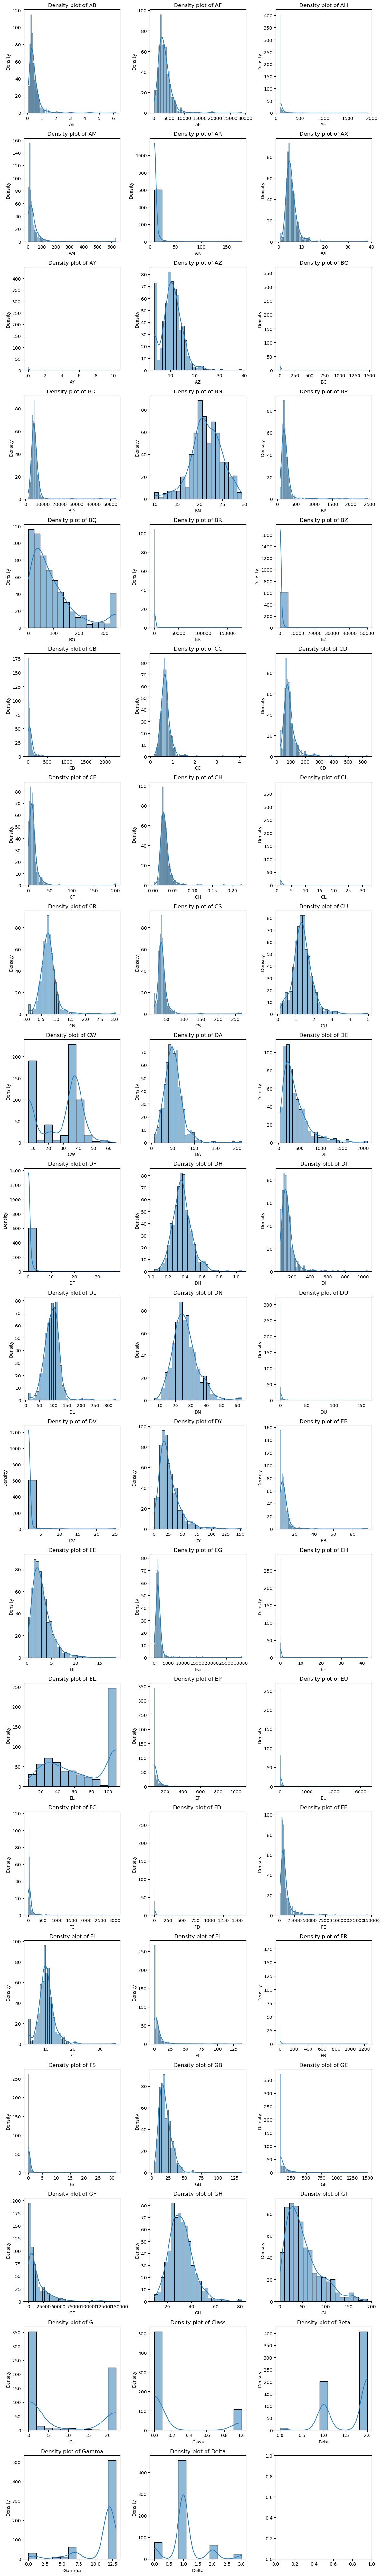

In [14]:
numerical_columns = merged_train_csv.select_dtypes(exclude='object').columns
num_plots = len(numerical_columns)
num_rows = (num_plots - 1) // 3 + 1  # Adjust the number of rows as needed

fig, axes = plt.subplots(num_rows, 3, figsize=(12, num_rows*4))  # Adjust the figure size as needed

for i, column in enumerate(numerical_columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.histplot(merged_train_csv[column], kde=True, ax=ax)
    ax.set_title(f'Density plot of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

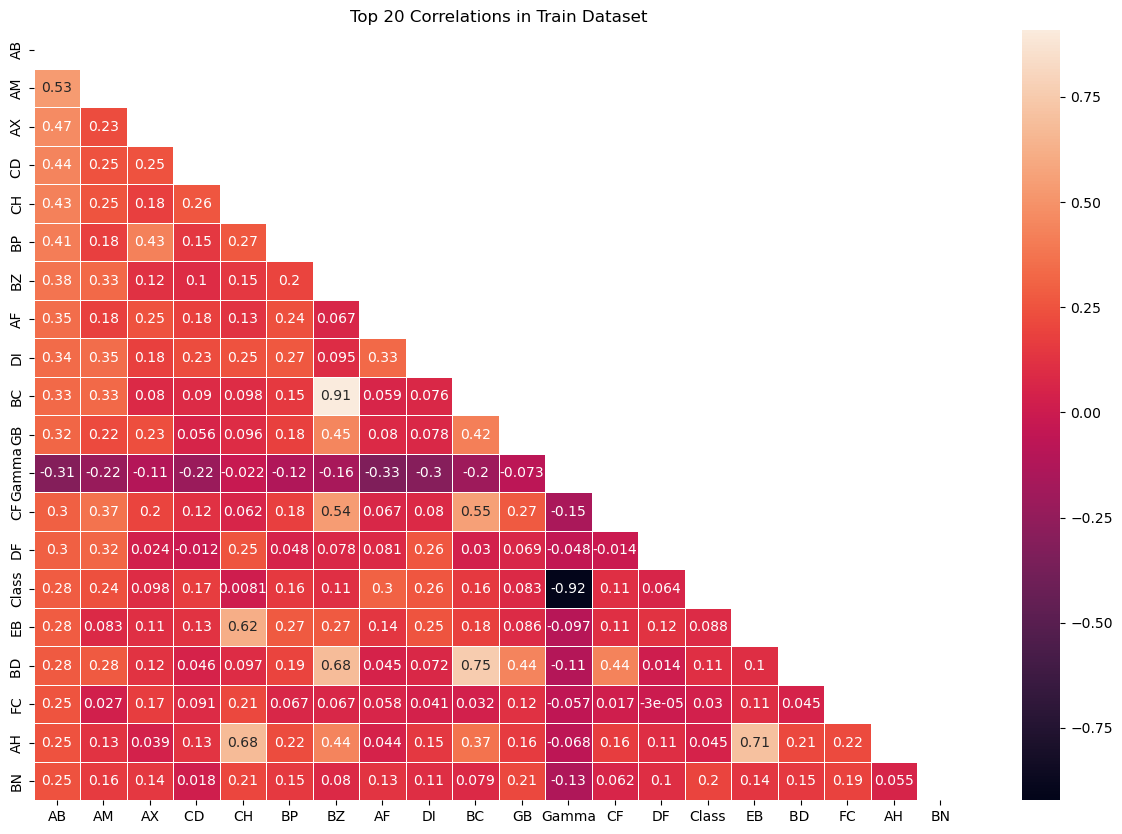

In [15]:
def plot_top_correlations(df: pd.core.frame.DataFrame, n: int, title_name: str='Top Correlations') -> None:
    # Calculate correlation between all variables
    corr = df.corr()

    # Select variables having highest absolute correlation
    top_corr_cols = corr.abs().nlargest(n, columns=corr.columns).index
    top_corr = corr.loc[top_corr_cols, top_corr_cols]

    fig, axes = plt.subplots(figsize=(15, 10))
    mask = np.zeros_like(top_corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(top_corr, mask=mask, linewidths=.5, annot=True)
    plt.title(title_name)
    plt.show()

# Plot heatmap of top 12 correlations in training data
plot_top_correlations(merged_train_csv[numerical_columns], 20, 'Top 20 Correlations in Train Dataset')

## Modeling

### Competition Loss function

In [16]:
def balanced_log_loss(y_true, y_pred):
    def calculate_weight(nc, y_true):
        return 1 / (nc / y_true.shape[0])

    def calculate_loss(y_true, y_pred, class_index):
        indicator = tf.where(y_true == class_index, 1, 0)
        weighted_loss = tf.reduce_sum(indicator * tf.math.log(y_pred[:, class_index]))
        return weighted_loss

    if y_pred.ndim > 1 and y_pred.shape[1] > 1:  # Probability array
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        nc = np.bincount(y_true)
        w0, w1 = calculate_weight(nc[0], y_true), calculate_weight(nc[1], y_true)
        loss_0 = calculate_loss(y_true, y_pred, 0)
        loss_1 = calculate_loss(y_true, y_pred, 1)
        balanced_log_loss_score = (-w0 * loss_0 - w1 * loss_1) / (w0 + w1)
        return balanced_log_loss_score
    else:  # Class prediction array
        y_pred_proba = np.zeros((y_true.shape[0], 2))
        y_pred_proba[np.arange(y_true.shape[0]), y_pred] = 1
        y_pred_proba = np.clip(y_pred_proba, 1e-15, 1 - 1e-15)
        nc = np.bincount(y_true)
        w0, w1 = calculate_weight(nc[0], y_true), calculate_weight(nc[1], y_true)
        loss_0 = calculate_loss(y_true, y_pred_proba, 0)
        loss_1 = calculate_loss(y_true, y_pred_proba, 1)
        balanced_log_loss_score = (-w0 * loss_0 - w1 * loss_1) / (w0 + w1)
        return balanced_log_loss_score


# def balanced_log_loss(y_true, y_pred):
#     def calculate_weight(nc, y_true):
#         return 1 / (nc / y_true.shape[0])

#     def calculate_loss(y_true, y_pred, class_index):
#         indicator = np.where(y_true == class_index, 1, 0)
#         weighted_loss = np.sum(indicator * np.log(y_pred[:, class_index]))
#         return weighted_loss

#     if y_pred.ndim > 1 and y_pred.shape[1] > 1:  # Probability array
#         y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
#         nc = np.bincount(y_true)
#         w0, w1 = calculate_weight(nc[0], y_true), calculate_weight(nc[1], y_true)
#         loss_0 = calculate_loss(y_true, y_pred, 0)
#         loss_1 = calculate_loss(y_true, y_pred, 1)
#         balanced_log_loss_score = (-w0 * loss_0 - w1 * loss_1) / (w0 + w1)
#         return balanced_log_loss_score
#     else:  # Class prediction array
#         y_pred_proba = np.zeros((y_true.shape[0], 2))
#         y_pred_proba[np.arange(y_true.shape[0]), y_pred] = 1
#         y_pred_proba = np.clip(y_pred_proba, 1e-15, 1 - 1e-15)
#         nc = np.bincount(y_true)
#         w0, w1 = calculate_weight(nc[0], y_true), calculate_weight(nc[1], y_true)
#         loss_0 = calculate_loss(y_true, y_pred_proba, 0)
#         loss_1 = calculate_loss(y_true, y_pred_proba, 1)
#         balanced_log_loss_score = (-w0 * loss_0 - w1 * loss_1) / (w0 + w1)
#         return balanced_log_loss_score

### Multi Neural Network

In [17]:
label_encoder = LabelEncoder()

merged_train_csv['EJ'] = label_encoder.fit_transform(merged_train_csv['EJ'])
merged_train_csv['Alpha'] = label_encoder.fit_transform(merged_train_csv['Alpha'])
merged_train_csv['Beta'] = label_encoder.fit_transform(merged_train_csv['Beta'])
merged_train_csv['Gamma'] = label_encoder.fit_transform(merged_train_csv['Gamma'])
merged_train_csv['Delta'] = label_encoder.fit_transform(merged_train_csv['Delta'])
merged_train_csv['Epsilon'] = label_encoder.fit_transform(merged_train_csv['Epsilon'])

In [18]:
master_features = ['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'Alpha',
       'Beta', 'Gamma', 'Delta', 'Epsilon']

In [19]:
features = ['Beta', 'Gamma', 'Delta']
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(merged_train_csv[features],merged_train_csv['Class'],test_size=0.2,random_state=99)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=99)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the MLP model
model_delta = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model_delta.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_delta.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=10, batch_size=64)

# Evaluate the model on the test set
loss, accuracy = model_delta.evaluate(X_test_scaled, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/10
7/7 [==============================] - 6s 52ms/step - loss: 0.5955 - accuracy: 0.7792 - val_loss: 0.7452 - val_accuracy: 0.6667
Epoch 2/10
7/7 [==============================] - 0s 11ms/step - loss: 0.3906 - accuracy: 0.9391 - val_loss: 0.6654 - val_accuracy: 0.9798
Epoch 3/10
7/7 [==============================] - 0s 14ms/step - loss: 0.2933 - accuracy: 0.9746 - val_loss: 0.6013 - val_accuracy: 0.9899
Epoch 4/10
7/7 [==============================] - 0s 13ms/step - loss: 0.2519 - accuracy: 0.9797 - val_loss: 0.5489 - val_accuracy: 0.9899
Epoch 5/10
7/7 [==============================] - 0s 13ms/step - loss: 0.2216 - accuracy: 0.9924 - val_loss: 0.5082 - val_accuracy: 0.9899
Epoch 6/10
7/7 [==============================] - 0s 10ms/step - loss: 0.1918 - accuracy: 0.9949 - val_loss: 0.4748 - val_accuracy: 0.9495
Epoch 7/10
7/7 [==============================] - 0s 11ms/step - loss: 0.1946 - accuracy: 0.9898 - val_loss: 0.4430 - val_accuracy: 0.9394
Epoch 8/10
7/7 [===========

In [20]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(train_csv[features],train_csv['Class'],test_size=0.2,random_state=99)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=99)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the MLP model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=10, batch_size=64)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_labels)

# Calculate log loss
logloss = log_loss(y_test, y_pred)

# Calculate balanced log loss
balanced_log_loss = logloss / np.log(4)

print('Balanced Log Loss:', balanced_log_loss)

Epoch 1/10
7/7 [==============================] - 2s 43ms/step - loss: 0.9074 - accuracy: 0.5406 - val_loss: 0.7595 - val_accuracy: 0.6970
Epoch 2/10
7/7 [==============================] - 0s 13ms/step - loss: 0.7697 - accuracy: 0.6650 - val_loss: 0.7268 - val_accuracy: 0.7374
Epoch 3/10
7/7 [==============================] - 0s 10ms/step - loss: 0.6488 - accuracy: 0.7843 - val_loss: 0.6948 - val_accuracy: 0.7677
Epoch 4/10
7/7 [==============================] - 0s 11ms/step - loss: 0.6060 - accuracy: 0.8096 - val_loss: 0.6574 - val_accuracy: 0.8283
Epoch 5/10
7/7 [==============================] - 0s 13ms/step - loss: 0.5754 - accuracy: 0.8147 - val_loss: 0.6109 - val_accuracy: 0.8889
Epoch 6/10
7/7 [==============================] - 0s 13ms/step - loss: 0.5350 - accuracy: 0.8274 - val_loss: 0.5804 - val_accuracy: 0.9091
Epoch 7/10
7/7 [==============================] - 0s 11ms/step - loss: 0.4779 - accuracy: 0.9036 - val_loss: 0.5597 - val_accuracy: 0.9192
Epoch 8/10
7/7 [===========

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               7296      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 1)                

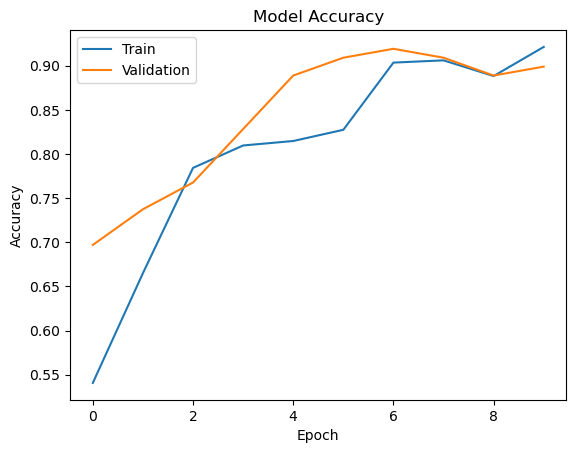

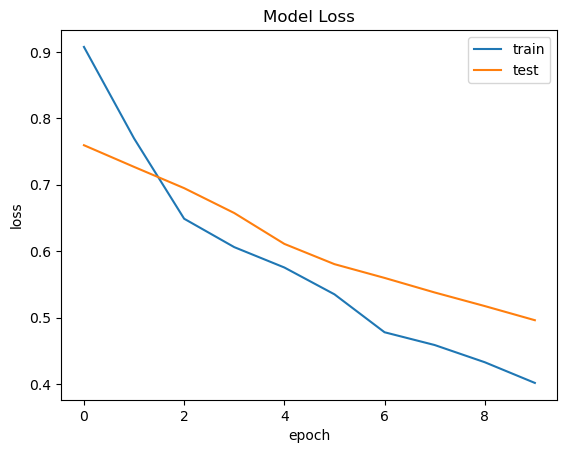

In [21]:
print(model.summary())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [22]:
categorical_pred = np.argmax(model.predict(X_test), axis=1)

print('Results for Categorical Model')
print(accuracy_score(y_test, categorical_pred))
print(classification_report(y_test, categorical_pred))

4/4 [==============================] - 0s 2ms/step
Results for Categorical Model
0.8064516129032258
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       100
           1       0.00      0.00      0.00        24

    accuracy                           0.81       124
   macro avg       0.40      0.50      0.45       124
weighted avg       0.65      0.81      0.72       124



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
test_csv_scaled = scaler.transform(test_csv[features])
y_pred = model.predict(test_csv[features])
my_submission = test_csv.copy()
my_submission = my_submission[['Id']]
my_submission['class_0'] = 1 - y_pred
my_submission['class_1'] = y_pred
my_submission

1/1 [==============================] - 0s 23ms/step


,Id,class_0,class_1
0,00eed32682bb,0.759502,0.240498
1,010ebe33f668,0.759502,0.240498
2,02fa521e1838,0.759502,0.240498
3,040e15f562a2,0.759502,0.240498
4,046e85c7cc7f,0.759502,0.240498


In [24]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(merged_train_csv[features],merged_train_csv['Beta'],test_size=0.2,random_state=99)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=99)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the MLP model
model_beta = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model_beta.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_beta.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=10, batch_size=64)

# Evaluate the model on the test set
loss, accuracy = model_beta.evaluate(X_test_scaled, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/10
7/7 [==============================] - 2s 43ms/step - loss: 1.5119 - accuracy: 0.3832 - val_loss: 1.0864 - val_accuracy: 0.6162
Epoch 2/10
7/7 [==============================] - 0s 13ms/step - loss: 1.1425 - accuracy: 0.5228 - val_loss: 1.0445 - val_accuracy: 0.6263
Epoch 3/10
7/7 [==============================] - 0s 11ms/step - loss: 1.0358 - accuracy: 0.6015 - val_loss: 1.0118 - val_accuracy: 0.6869
Epoch 4/10
7/7 [==============================] - 0s 10ms/step - loss: 0.9250 - accuracy: 0.6726 - val_loss: 0.9705 - val_accuracy: 0.7071
Epoch 5/10
7/7 [==============================] - 0s 11ms/step - loss: 0.8734 - accuracy: 0.6904 - val_loss: 0.9487 - val_accuracy: 0.7778
Epoch 6/10
7/7 [==============================] - 0s 13ms/step - loss: 0.7476 - accuracy: 0.7766 - val_loss: 0.9273 - val_accuracy: 0.7778
Epoch 7/10
7/7 [==============================] - 0s 11ms/step - loss: 0.7211 - accuracy: 0.8046 - val_loss: 0.9020 - val_accuracy: 0.7778
Epoch 8/10
7/7 [===========

In [25]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(merged_train_csv[features])
y_pred_beta = np.argmax(model_beta.predict(scaled_df), axis=1)
first_output = pd.DataFrame({'beta': y_pred_beta})
first_output

20/20 [==============================] - 0s 2ms/step


,beta
0,2
1,2
2,2
3,2
4,1
...,...
612,1
613,1
614,2
615,2


In [26]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(merged_train_csv[features],merged_train_csv['Gamma'],test_size=0.2,random_state=99)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=99)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the MLP model
model_gamma = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model_gamma.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_gamma.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=10, batch_size=64)

# Evaluate the model on the test set
loss, accuracy = model_gamma.evaluate(X_test_scaled, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/10
7/7 [==============================] - 3s 42ms/step - loss: 2.7723 - accuracy: 0.1269 - val_loss: 1.9357 - val_accuracy: 0.4646
Epoch 2/10
7/7 [==============================] - 0s 11ms/step - loss: 2.3544 - accuracy: 0.2437 - val_loss: 1.9082 - val_accuracy: 0.4747
Epoch 3/10
7/7 [==============================] - 0s 13ms/step - loss: 2.0607 - accuracy: 0.3858 - val_loss: 1.8634 - val_accuracy: 0.5253
Epoch 4/10
7/7 [==============================] - 0s 12ms/step - loss: 1.8467 - accuracy: 0.4594 - val_loss: 1.8094 - val_accuracy: 0.5657
Epoch 5/10
7/7 [==============================] - 0s 14ms/step - loss: 1.6819 - accuracy: 0.5381 - val_loss: 1.7486 - val_accuracy: 0.6162
Epoch 6/10
7/7 [==============================] - 0s 11ms/step - loss: 1.5492 - accuracy: 0.6041 - val_loss: 1.6846 - val_accuracy: 0.6667
Epoch 7/10
7/7 [==============================] - 0s 13ms/step - loss: 1.4388 - accuracy: 0.6168 - val_loss: 1.6101 - val_accuracy: 0.7172
Epoch 8/10
7/7 [===========

In [27]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(merged_train_csv[features])
y_pred_gamma = np.argmax(model_gamma.predict(scaled_df), axis=1)
new_column = pd.DataFrame({'gamma': y_pred_gamma})
first_output = pd.concat([first_output, new_column], axis=1)
first_output

20/20 [==============================] - 0s 2ms/step


,beta,gamma
0,2,4
1,2,6
2,2,7
3,2,6
4,1,5
...,...,...
612,1,6
613,1,6
614,2,6
615,2,6


In [28]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(merged_train_csv[features],merged_train_csv['Delta'],test_size=0.2,random_state=99)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=99)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the MLP model
model_delta = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model_delta.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_delta.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=10, batch_size=64)

# Evaluate the model on the test set
loss, accuracy = model_delta.evaluate(X_test_scaled, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/10
7/7 [==============================] - 3s 40ms/step - loss: 1.8801 - accuracy: 0.3122 - val_loss: 1.4904 - val_accuracy: 0.3232
Epoch 2/10
7/7 [==============================] - 0s 11ms/step - loss: 1.5025 - accuracy: 0.4340 - val_loss: 1.4066 - val_accuracy: 0.5152
Epoch 3/10
7/7 [==============================] - 0s 10ms/step - loss: 1.3797 - accuracy: 0.5254 - val_loss: 1.3280 - val_accuracy: 0.6061
Epoch 4/10
7/7 [==============================] - 0s 10ms/step - loss: 1.2561 - accuracy: 0.5406 - val_loss: 1.2439 - val_accuracy: 0.6667
Epoch 5/10
7/7 [==============================] - 0s 11ms/step - loss: 1.1183 - accuracy: 0.5990 - val_loss: 1.1812 - val_accuracy: 0.7071
Epoch 6/10
7/7 [==============================] - 0s 11ms/step - loss: 1.0499 - accuracy: 0.6650 - val_loss: 1.1376 - val_accuracy: 0.7475
Epoch 7/10
7/7 [==============================] - 0s 13ms/step - loss: 0.9687 - accuracy: 0.6929 - val_loss: 1.0920 - val_accuracy: 0.7879
Epoch 8/10
7/7 [===========

In [29]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(merged_train_csv[features])
y_pred_delta = np.argmax(model_delta.predict(scaled_df), axis=1)
new_column = pd.DataFrame({'delta': y_pred_delta})
first_output = pd.concat([first_output, new_column], axis=1)
first_output

20/20 [==============================] - 0s 2ms/step


,beta,gamma,delta
0,2,4,3
1,2,6,1
2,2,7,1
3,2,6,1
4,1,5,1
...,...,...,...
612,1,6,1
613,1,6,1
614,2,6,2
615,2,6,1


In [30]:
features = ['delta', 'beta', 'gamma']
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(first_output[features],merged_train_csv['Class'],test_size=0.2,random_state=99)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=99)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the MLP model
model_class = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model_class.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_class.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=10, batch_size=64)

# Evaluate the model on the test set
loss, accuracy = model_class.evaluate(X_test_scaled, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/10
7/7 [==============================] - 3s 43ms/step - loss: 0.9190 - accuracy: 0.5584 - val_loss: 0.7686 - val_accuracy: 0.8384
Epoch 2/10
7/7 [==============================] - 0s 15ms/step - loss: 0.6860 - accuracy: 0.8223 - val_loss: 0.7560 - val_accuracy: 0.8384
Epoch 3/10
7/7 [==============================] - 0s 23ms/step - loss: 0.6402 - accuracy: 0.8528 - val_loss: 0.7459 - val_accuracy: 0.8384
Epoch 4/10
7/7 [==============================] - 0s 11ms/step - loss: 0.5936 - accuracy: 0.8782 - val_loss: 0.7292 - val_accuracy: 0.8384
Epoch 5/10
7/7 [==============================] - 0s 13ms/step - loss: 0.5328 - accuracy: 0.8832 - val_loss: 0.7124 - val_accuracy: 0.8384
Epoch 6/10
7/7 [==============================] - 0s 12ms/step - loss: 0.5185 - accuracy: 0.8909 - val_loss: 0.6945 - val_accuracy: 0.8687
Epoch 7/10
7/7 [==============================] - 0s 11ms/step - loss: 0.4967 - accuracy: 0.8985 - val_loss: 0.6800 - val_accuracy: 0.8687
Epoch 8/10
7/7 [===========

In [31]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(first_output[features])

y_pred = model_class.predict(scaled_df)
y_pred

20/20 [==============================] - 0s 2ms/step


array([[0.6203832 ],
       [0.32037097],
       [0.32279658],
       [0.32037097],
       [0.5375598 ],
       [0.32037097],
       [0.32037097],
       [0.32037097],
       [0.32037097],
       [0.32037097],
       [0.75250554],
       [0.32279658],
       [0.32279658],
       [0.75250554],
       [0.32666615],
       [0.7788605 ],
       [0.33070675],
       [0.32279658],
       [0.38101065],
       [0.32037097],
       [0.41918284],
       [0.32279658],
       [0.37023348],
       [0.32037097],
       [0.32037097],
       [0.32037097],
       [0.289492  ],
       [0.32037097],
       [0.32037097],
       [0.41918284],
       [0.32037097],
       [0.6642314 ],
       [0.5375598 ],
       [0.37023348],
       [0.35613084],
       [0.32037097],
       [0.5375598 ],
       [0.32037097],
       [0.32037097],
       [0.37023348],
       [0.32037097],
       [0.8022575 ],
       [0.32037097],
       [0.32279658],
       [0.32037097],
       [0.32037097],
       [0.32037097],
       [0.320

In [32]:
# Add columns with zeroes
num_columns = 4  # Number of columns to add
zero_columns = ['Beta', 'Gamma', 'Delta', 'Epsilon']  # Column names for zero columns
merged_test_csv = test_csv.assign(**{col: 0 for col in zero_columns[:num_columns]})
merged_test_csv

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GB,GE,GF,GH,GI,GL,Beta,Gamma,Delta,Epsilon
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


In [33]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
scaler = StandardScaler()
scaled_df = scaler.fit_transform(merged_test_csv[features])
y_pred_beta = np.argmax(model_beta.predict(scaled_df), axis=1)
first_output = pd.DataFrame({'beta': y_pred_beta})
first_output

1/1 [==============================] - 0s 24ms/step


,beta
0,2
1,2
2,2
3,2
4,2


In [34]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
scaler = StandardScaler()
scaled_df = scaler.fit_transform(merged_test_csv[features])
y_pred_gamma = np.argmax(model_gamma.predict(scaled_df), axis=1)
new_column = pd.DataFrame({'gamma': y_pred_gamma})
first_output = pd.concat([first_output, new_column], axis=1)
first_output

1/1 [==============================] - 0s 22ms/step


,beta,gamma
0,2,6
1,2,6
2,2,6
3,2,6
4,2,6


In [35]:
features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
scaler = StandardScaler()
scaled_df = scaler.fit_transform(merged_test_csv[features])
y_pred_delta = np.argmax(model_delta.predict(scaled_df), axis=1)
new_column = pd.DataFrame({'delta': y_pred_delta})
first_output = pd.concat([first_output, new_column], axis=1)
first_output

1/1 [==============================] - 0s 23ms/step


,beta,gamma,delta
0,2,6,1
1,2,6,1
2,2,6,1
3,2,6,1
4,2,6,1


### TABPFN

In [36]:
times = greeks_csv.Epsilon.copy()
times[greeks_csv.Epsilon != 'Unknown'] = greeks_csv.Epsilon[greeks_csv.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
times[greeks_csv.Epsilon == 'Unknown'] = np.nan

In [37]:
# Set predictor and target columns
target = 'Class'
predictors = [n for n in train_csv.columns if n != target and n != 'Id']

In [38]:
class WeightedEns(BaseEstimator):
    def __init__(self):
        self.classifiers = [xgb.XGBClassifier(learning_rate = 0.2, booster = 'dart'),TabPFNClassifier(N_ensemble_configurations=64)]
        self.imp = SimpleImputer(missing_values=np.nan, strategy='median')
    
    def fit(self, X, y):
        cls, y = np.unique(y, return_inverse=True)
        self.classes_ = cls
        X = self.imp.fit_transform(X)
        for cl in self.classifiers:
            cl.fit(X,y)
    
    def predict_proba(self, X):
        X = self.imp.transform(X)
        ps = np.stack([cl.predict_proba(X) for cl in self.classifiers])
        p = np.mean(ps,axis=0)
        class_0_est_instances = p[:,0].sum()
        others_est_instances = p[:,1:].sum()

        new_p = p * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(p.shape[1])]])
        return new_p / np.sum(new_p,axis=1,keepdims=1)

In [39]:
pred_and_time = pd.concat((train_csv[predictors], times), 1)

/tmp/ipykernel_23/2202716009.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pred_and_time = pd.concat((train_csv[predictors], times), 1)


In [40]:
test_predictors = np.array(test_csv[predictors])
test_pred_and_time = np.concatenate((test_predictors, np.zeros((len(test_predictors),1)) + pred_and_time.Epsilon.max()+1),1)

In [41]:
X = train_csv[predictors]
y = train_csv["Class"]

In [42]:
m = WeightedEns()

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [43]:
cv_scores = - sk.model_selection.cross_val_score(m, pred_and_time, greeks_csv['Alpha'], cv = 5, scoring = "neg_log_loss")

print(cv_scores)
print(np.mean(cv_scores))

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
[0.17080089 0.30526022 0.29626317 0.28100474 0.21219044]
0.2531038919498297


In [44]:
sk.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [45]:
m = WeightedEns()
m.fit(np.array(pred_and_time),np.array(greeks_csv['Alpha']))
p = m.predict_proba(test_pred_and_time)
assert (m.classes_[0] == 'A')
p = np.concatenate((p[:,:1],np.sum(p[:,1:],1,keepdims=True)), 1)


p0 = p[:,:1]
p0[p0 > 0.92] = 1
p0[p0 < 0.08] = 0
submit=pd.DataFrame(test_csv["Id"], columns=["Id"])
submit["class_0"] = p0
submit["class_1"] = 1 - p0
submit.to_csv('submission.csv',index=False)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [46]:
pd.read_csv('submission.csv')

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5
